In [1]:
install.packages("ggthemes")
library(umap)
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(viridis)
library(ggthemes)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”
Loading required package: viridisLite

Warning message:
“package ‘viridisLite’ was built under R version 4.2.3”


In [2]:
# set file path to the concatenated aggregated feature selected profiles
path.data = file.path("./results/batch1_concat_agg_fs.csv")
if (!file.exists(path.data)){
    stop("Concatenated aggregated feature selected profiles not found. Please run the 'preprocessing-data.ipynb' script first.")
}

concat.agg_fs_df = read.csv(path.data)

In [3]:
# setting metadata to keep
sel_metadata <- c("Metadata_plate_barcode", "Metadata_control_type", "Metadata_Pathway")

# separating metadata and morphology data
metadata_df <- concat.agg_fs_df[,sel_metadata]
morphology_df <- concat.agg_fs_df[,!grepl("^Metadata_", colnames(concat.agg_fs_df))]

## Creating correlation heat map 

In [4]:
annotation_colors <- list(
  Metadata_plate_barcode = c(
    "localhost240927060001" = "#8DD3C7",
    "localhost240928120001" = "#FFFFB3",
    "localhost240926150001" = "#BEBADA",
    "localhost240927120001" = "#FB8072"
  ),
  
  Metadata_control_type = c(
    "positive" = "#8DD3C7",
    "trt" = "#FFFFB3",
    "negative" = "#BEBADA"
  ),
  
  Metadata_Pathway = c(
    "1" = "#8DD3C7",
    "Apoptosis" = "#D9F0B9",
    "Angiogenesis" = "#E9E8C0",
    "Others" = "#BEBADA",
    "Endocrinology & Hormones" = "#E69394",
    "GPCR & G Protein" = "#D29092",
    "Neuronal Signaling" = "#80B1D3",
    "DNA Damage" = "#D3B387",
    "Stem Cells & Wnt" = "#E4C264",
    "Metabolism" = "#B3DE69",
    "MAPK" = "#E3D2BB",
    "Epigenetics" = "#F0D1E1",
    "PI3K/Akt/mTOR" = "#D9D9D9"
  )
)

In [5]:
cor_matrix <- cor(morphology_df, use = "pairwise.complete.obs", method = "pearson")


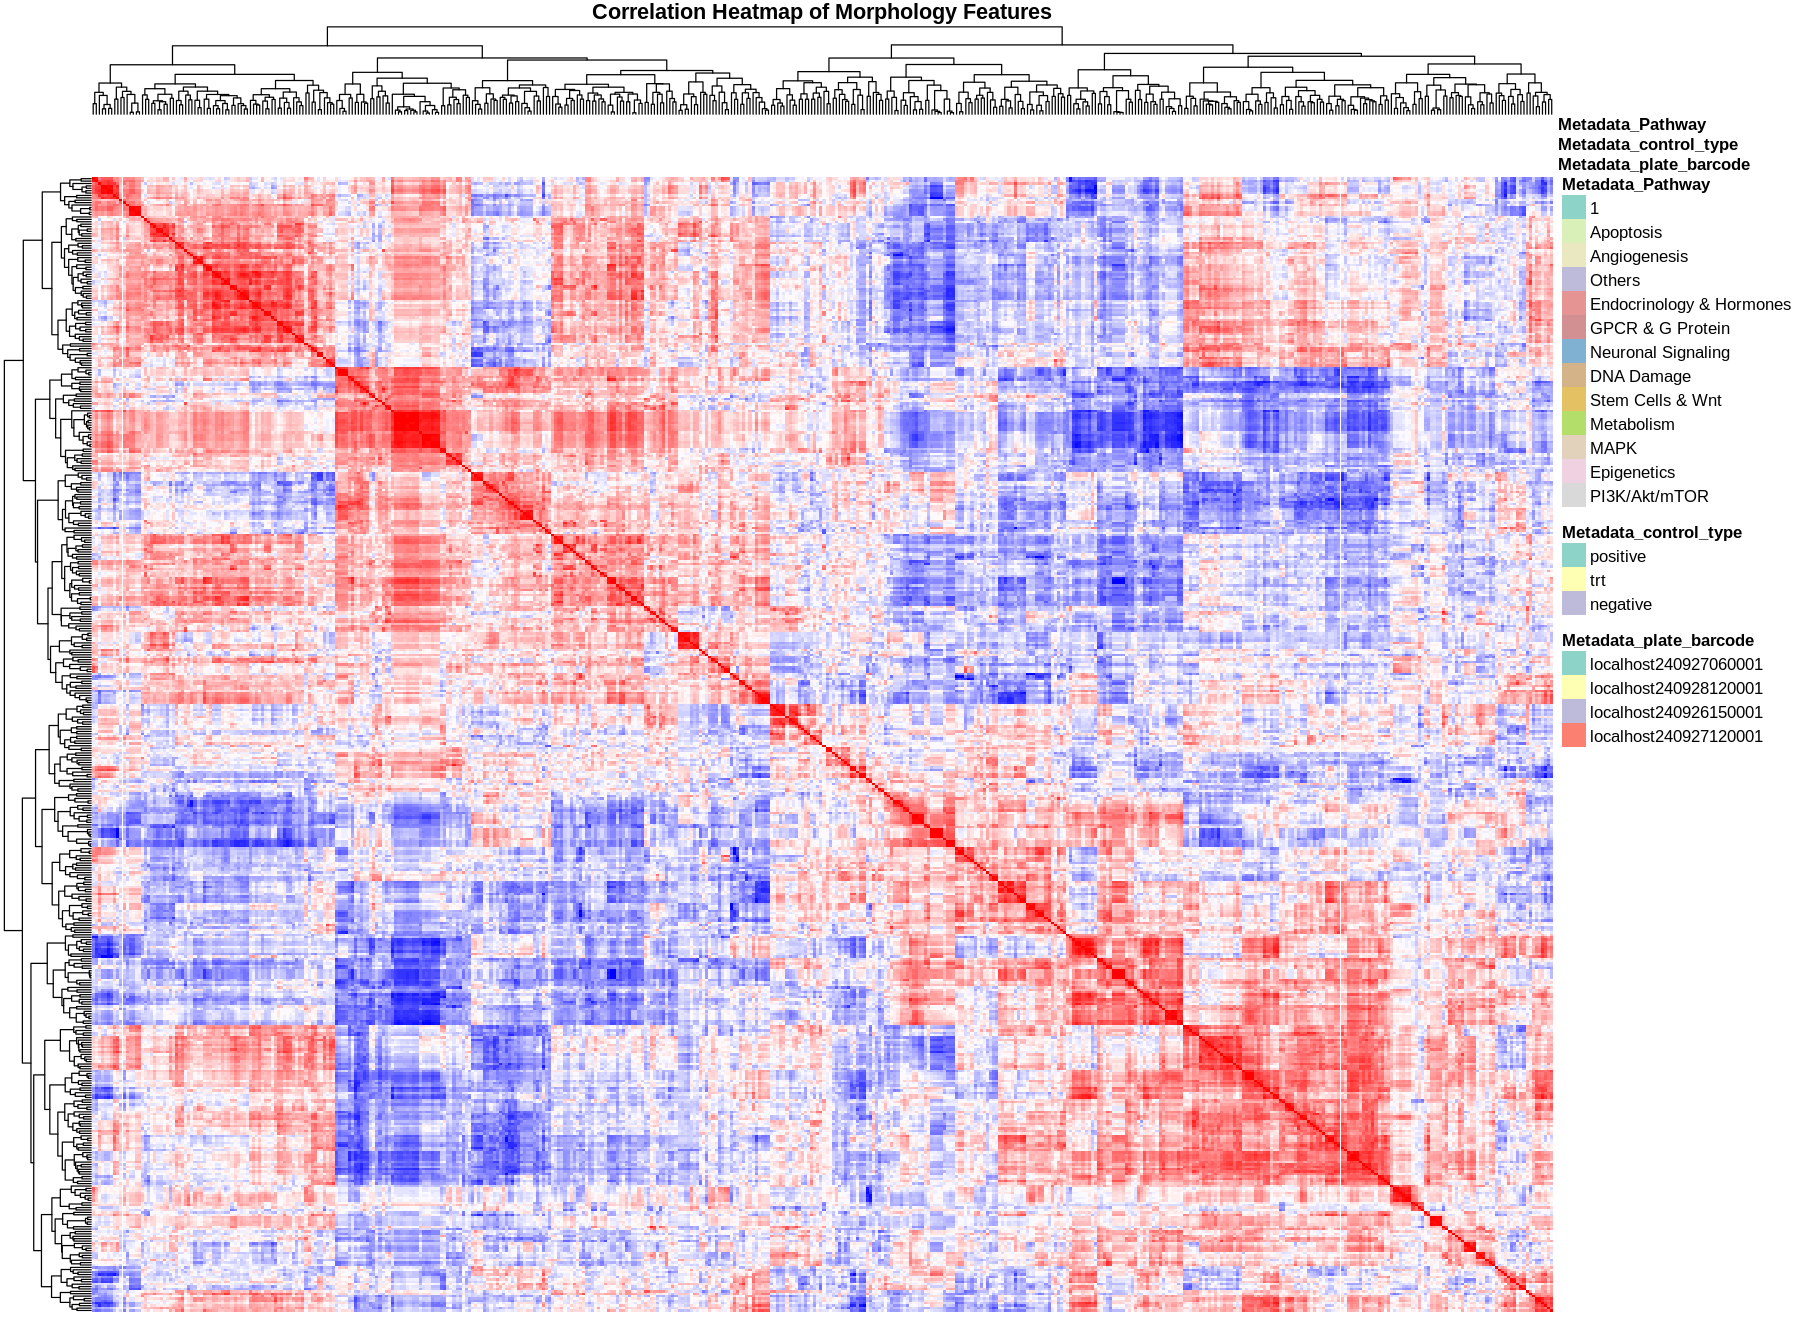

In [ ]:
# NOTE: use complex heatmap to visualize the correlation matrix
options(repr.plot.width=15, repr.plot.height=11)
pheatmap(cor_matrix, 
         annotation_col = metadata_df, 
         annotation_colors = annotation_colors, 
         color = colorRampPalette(c("blue", "white", "red"))(50),
         clustering_method = "complete",
         main = "Correlation Heatmap of Morphology Features",
         show_rownames = FALSE,  
         show_colnames = FALSE,  
         legend = FALSE,
         border_color = "gray",  # Make borders visible
)

## Creating a UMAP plot

In [7]:
library(RColorBrewer)

In [8]:
# filter the main dataframe concat.agg_fs_df to only select control profiles where Metadata_treatment is DMSO
control_df <- concat.agg_fs_df[concat.agg_fs_df$Metadata_treatment == "DMSO",]
control_morphology_df <- control_df[,!grepl("^Metadata_", colnames(control_df))]

# Generate UMAP for control profiles
umap_result <- umap(control_morphology_df, n_components = 2)
umap_control_df <- data.frame(
  UMAP1 = umap_result$layout[,1],
  UMAP2 = umap_result$layout[,2],
  Plate = control_df$Metadata_plate_barcode,
  ControlType = control_df$Metadata_control_type
)


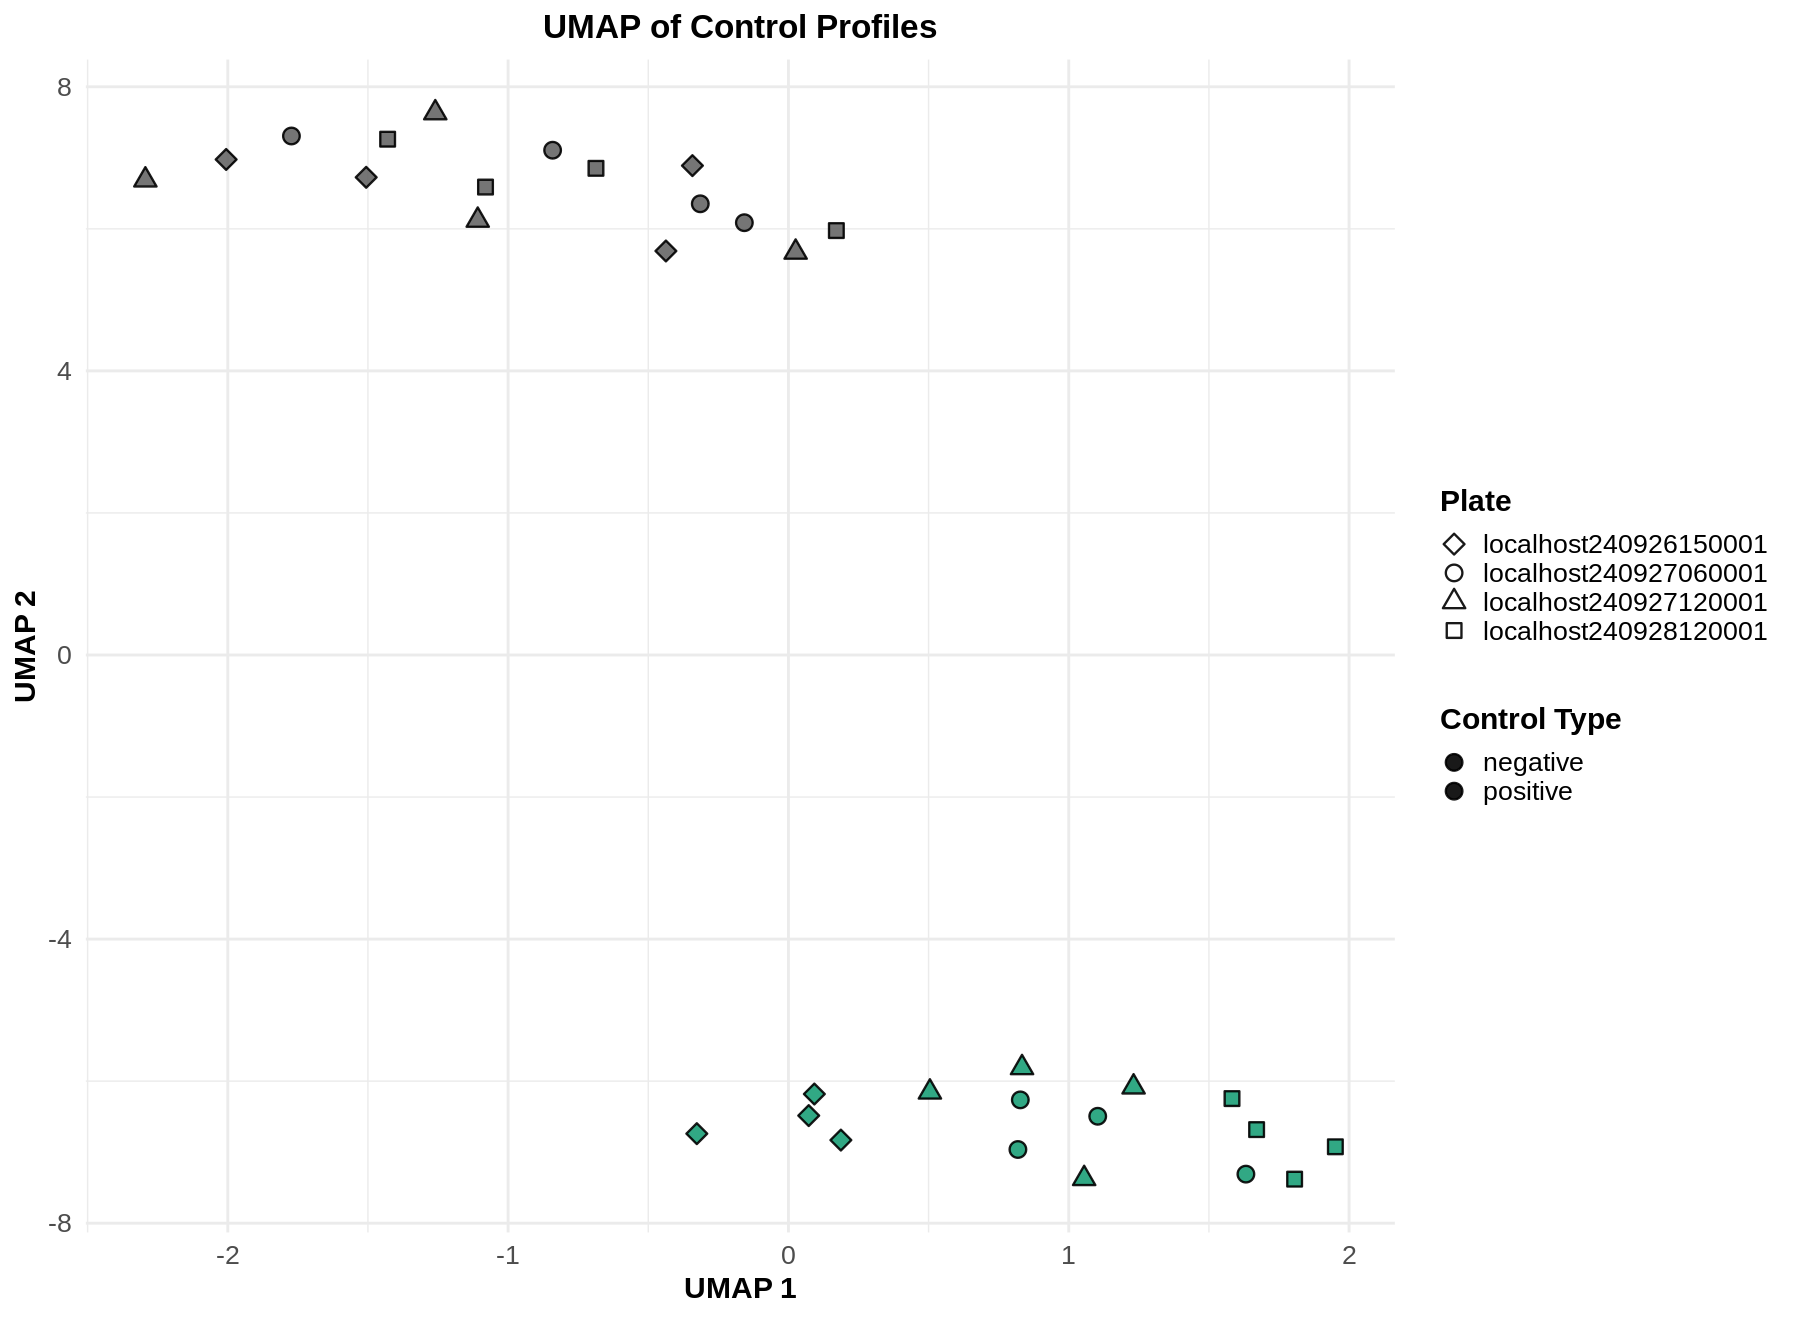

In [9]:
# make figure larger
options(repr.plot.width=15, repr.plot.height=11)

# Generate a color palette dynamically for ControlType (colorblind-friendly)
control_colors <- setNames(
  colorRampPalette(brewer.pal(8, "Dark2"))(length(unique(umap_control_df$ControlType))),
  unique(umap_control_df$ControlType)
)

# Define distinct filled shapes for Plate (21–25 allow fill)
plate_shapes <- c(21, 22, 23, 24, 25)  # These allow filling
names(plate_shapes) <- unique(umap_control_df$Plate)

# Plot UMAP with enhanced aesthetics for publication
ggplot(umap_control_df, aes(x = UMAP1, y = UMAP2, shape = Plate, fill = ControlType)) +
  geom_point(size = 4, stroke = 1, color = "black", alpha = 0.9) +  # Larger points with black border
  scale_shape_manual(values = plate_shapes) +  # Assign shapes to Plate
  scale_fill_manual(values = control_colors) +  # Fill shapes by ControlType
  theme_minimal(base_size = 18) +  # Increase base font size
  labs(
    title = "UMAP of Control Profiles",
    x = "UMAP 1",
    y = "UMAP 2",
    fill = "Control Type",  # Legend title for fill
    shape = "Plate"  # Legend title for shape
  ) +
  theme(
    legend.position = "right",  # Place legend on the right
    legend.text = element_text(size = 16),  # Increase legend text size
    legend.title = element_text(size = 18, face = "bold"),  # Bold legend title
    axis.text = element_text(size = 16),  # Increase axis text size
    axis.title = element_text(size = 18, face = "bold"),  # Bold axis labels
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5)  # Centered title
  )


Making a UMAP of all morphology features

In [10]:
# Extract only morphology data (exclude metadata)
morphology_features <- morphology_df  

# Ensure row names in metadata match morphology_features
rownames(metadata_df) <- rownames(morphology_features)

# Perform UMAP
umap_result <- umap(morphology_features, n_components = 2)

# Create a data frame with UMAP results and metadata
umap_df <- data.frame(
  UMAP1 = umap_result$layout[,1],
  UMAP2 = umap_result$layout[,2],
  Plate = metadata_df$Metadata_plate_barcode,
  Pathway = metadata_df$Metadata_Pathway
)

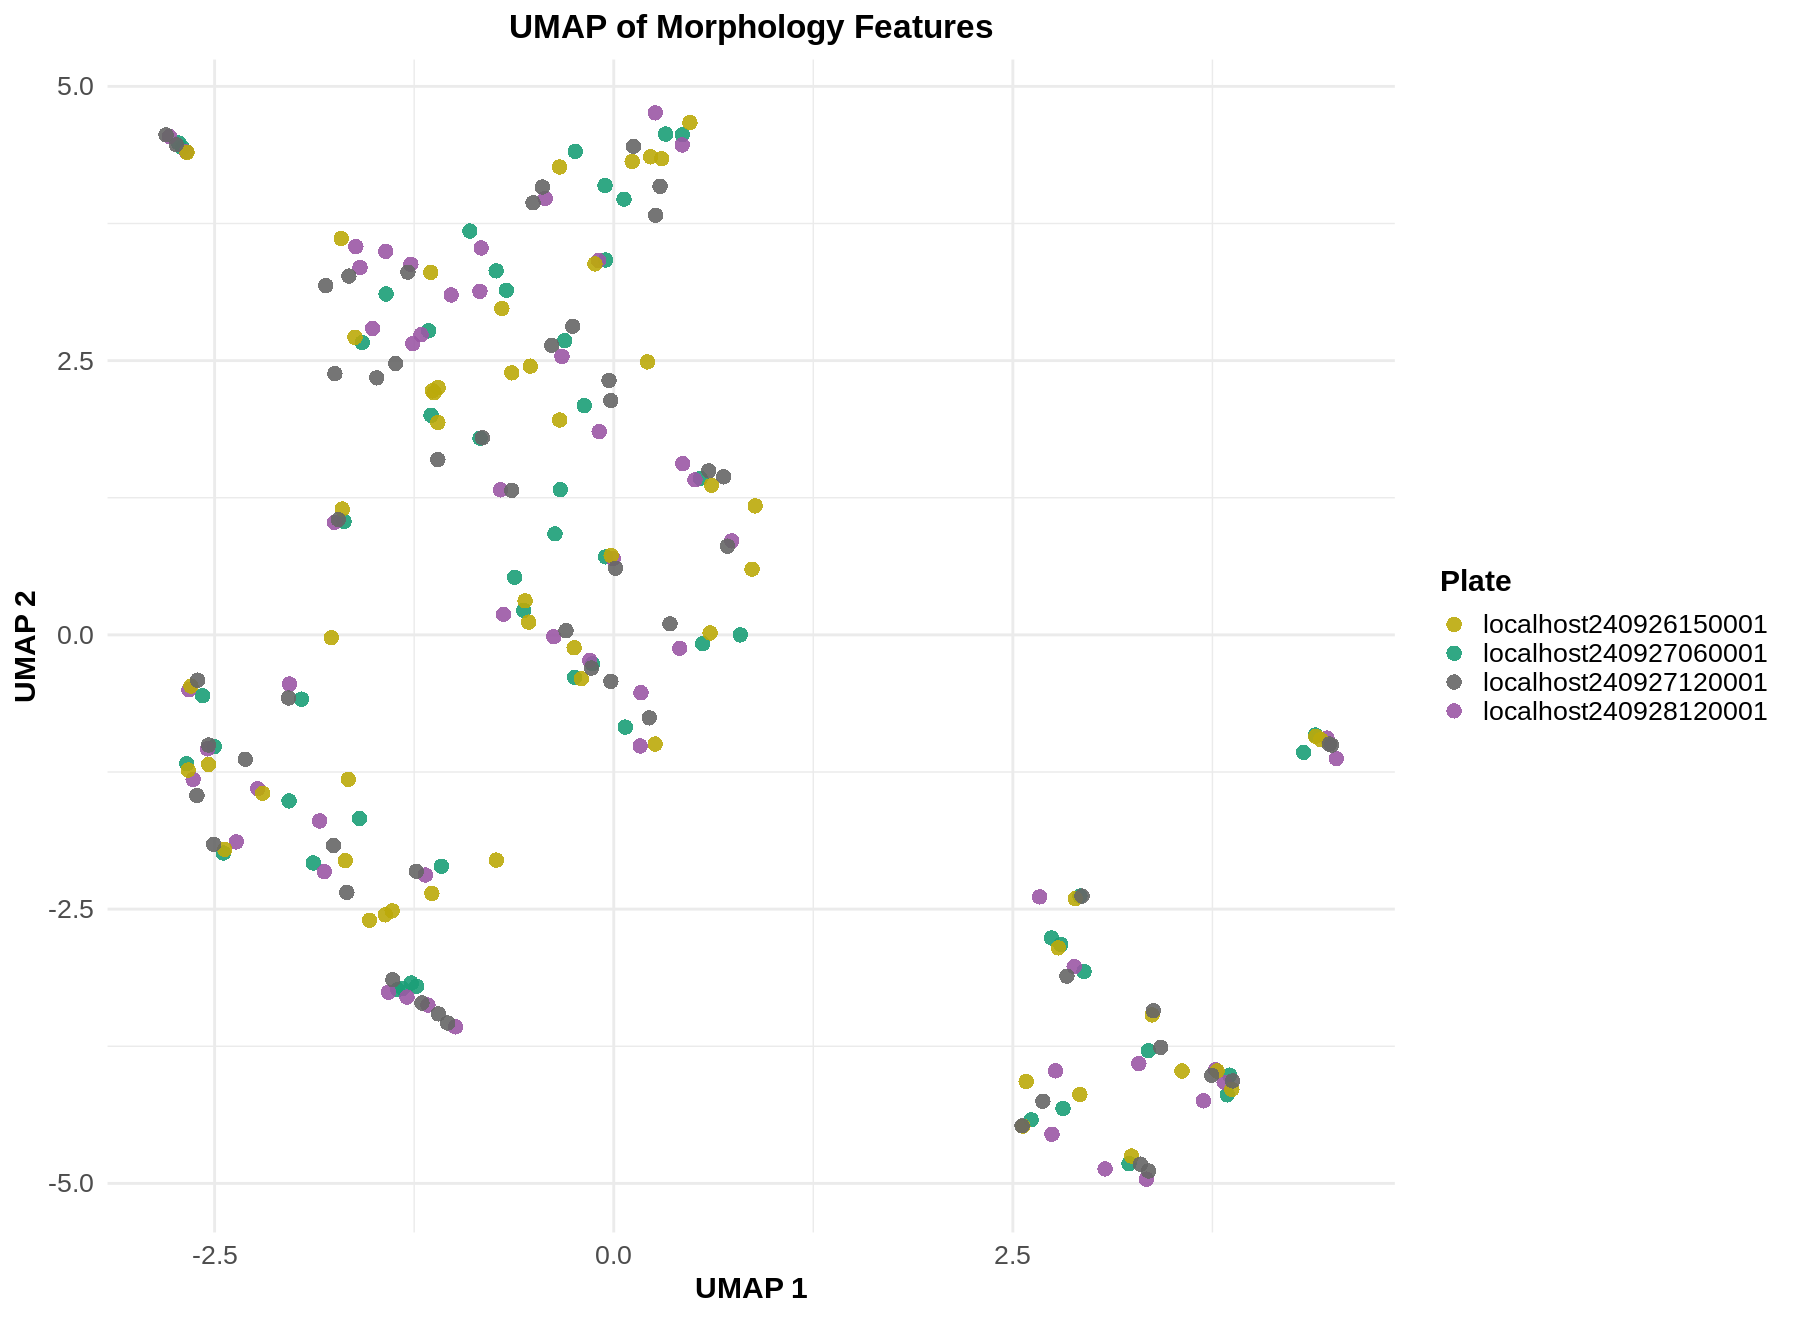

In [11]:
# Generate a color palette dynamically for unique plates (colorblind-friendly)
plate_colors <- setNames(
  colorRampPalette(brewer.pal(8, "Dark2"))(length(unique(umap_df$Plate))),  
  unique(umap_df$Plate)
)

# Plot UMAP with enhanced aesthetics for publication
ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Plate)) +
  geom_point(alpha = 0.9, size = 4, shape = 16) +  # Larger points with higher opacity
  scale_color_manual(values = plate_colors) +  # Use colorblind-friendly palette
  theme_minimal(base_size = 18) +  # Increase base font size
  labs(
    title = "UMAP of Morphology Features",
    x = "UMAP 1",
    y = "UMAP 2",
    color = "Plate"  # Legend title
  ) +
  theme(
    legend.position = "right",  # Place legend on the right
    legend.text = element_text(size = 16),  # Increase legend text size
    legend.title = element_text(size = 18, face = "bold"),  # Bold legend title
    axis.text = element_text(size = 16),  # Increase axis text size
    axis.title = element_text(size = 18, face = "bold"),  # Bold axis labels
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5)  # Centered title
  )

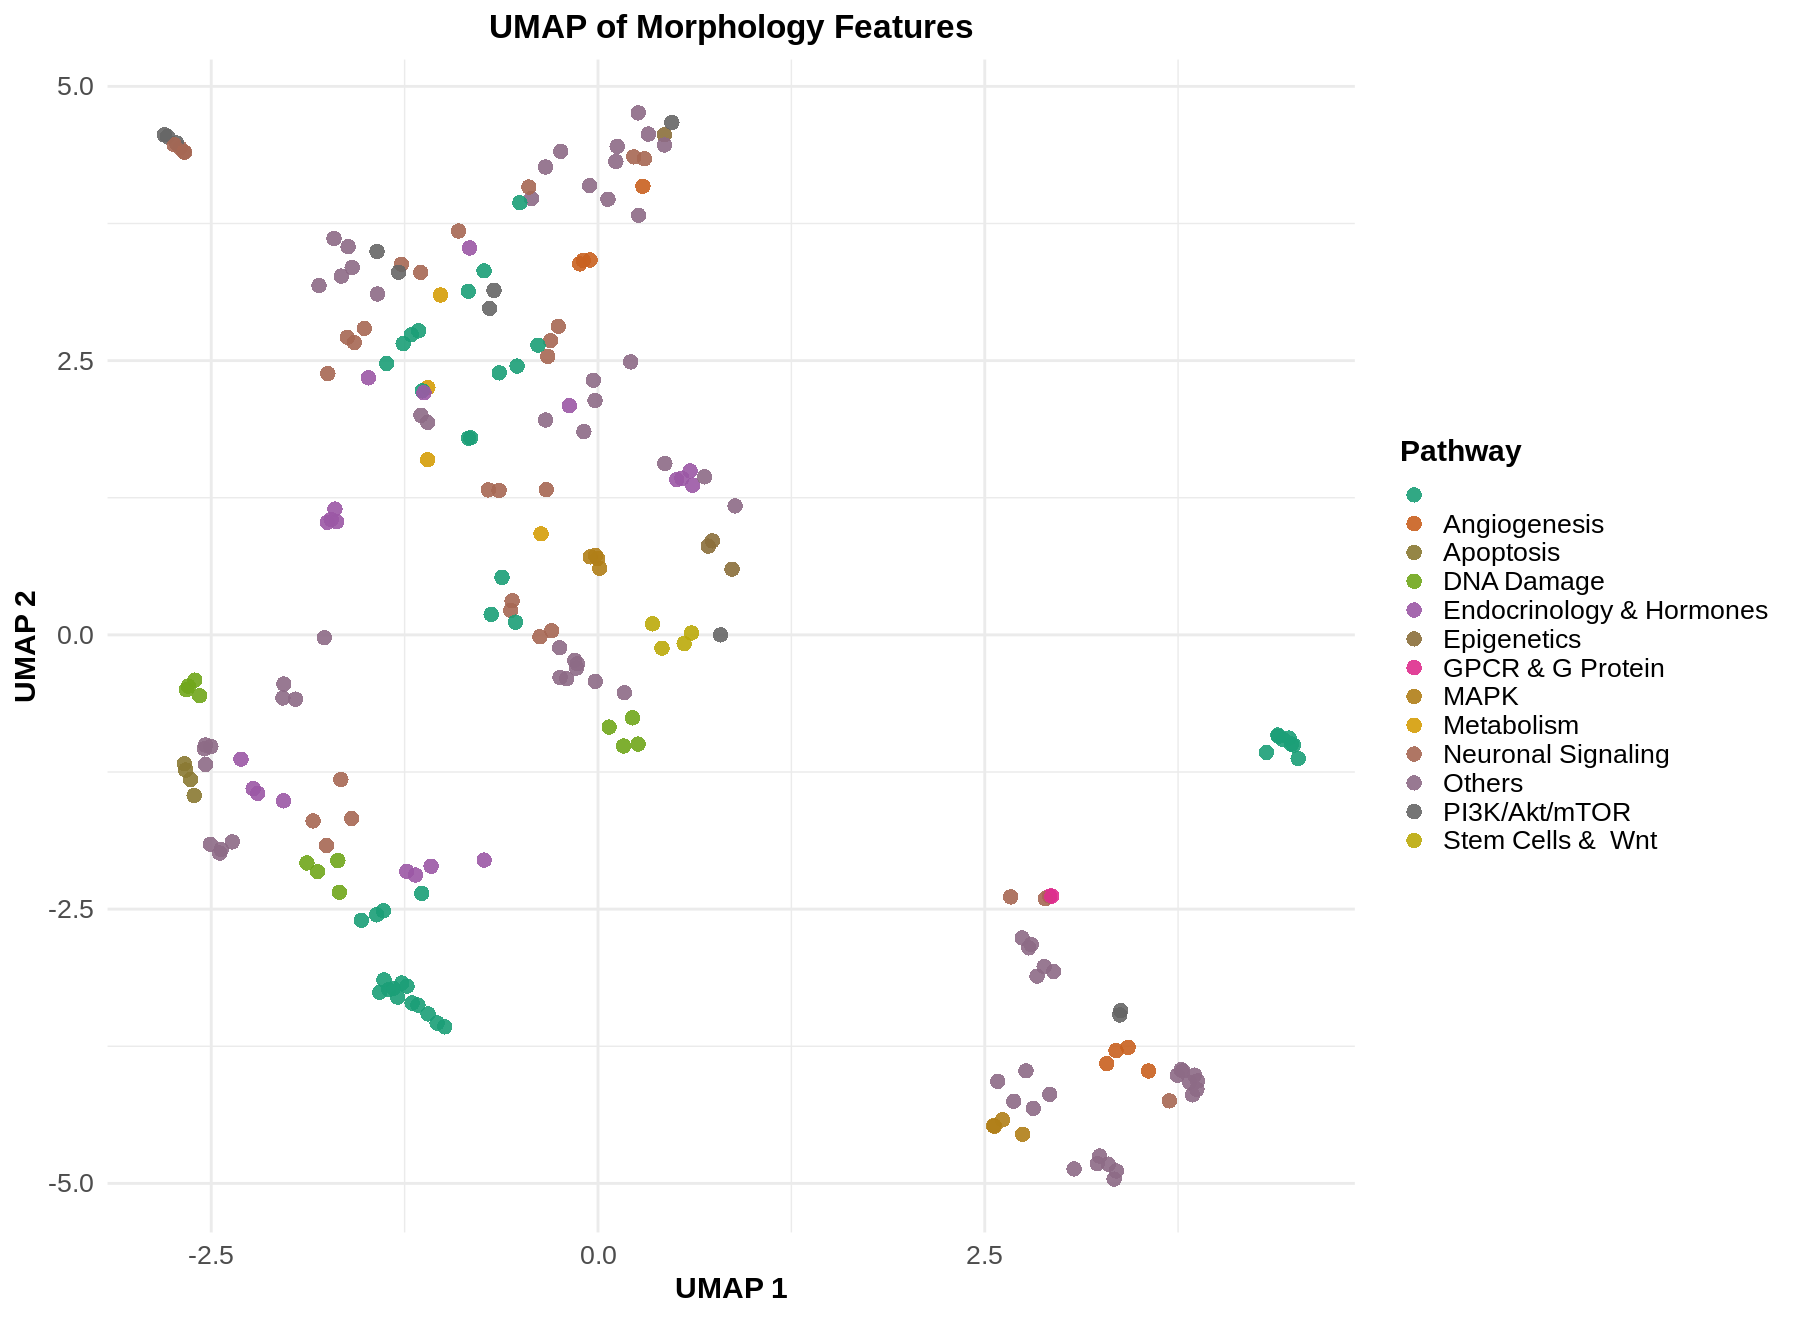

In [12]:
# Generate a color palette dynamically for unique plates (colorblind-friendly)
plate_colors <- setNames(
  colorRampPalette(brewer.pal(8, "Dark2"))(length(unique(umap_df$Pathway))),  
  unique(umap_df$Pathway)
)
# Plotting UMAP coloring based on the Pathway
ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Pathway)) +
  geom_point(alpha = 0.9, size = 4, shape = 16) +  
  scale_color_manual(values = plate_colors) +  
  theme_minimal(base_size = 18) +  
  labs(
    title = "UMAP of Morphology Features",
    x = "UMAP 1",
    y = "UMAP 2",
    color = "Pathway"
  ) +
  theme(
    legend.position = "right",  
    legend.text = element_text(size = 16),  
    legend.title = element_text(size = 18, face = "bold"),  
    axis.text = element_text(size = 16),  
    axis.title = element_text(size = 18, face = "bold"), 
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5)  
  )